In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# -------------------------------
# Step 1: Load Medical Dataset
# -------------------------------
data = load_breast_cancer()
X = data.data
y = data.target
feature_names = data.feature_names

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)


In [7]:
features = {
    "mean_radius": (-0.2, 3),
    "mean_texture": (0.6, 4),
    "mean_perimeter": (0.8, 5),
    "mean_area": (1.0, 7),
    "mean_smoothness": (1.2, 9),
    "mean_compactness": (1.4, 8),
    "mean_concavity": (1.6, 7),
    "mean_concave_points": (1.8, 6),
    "mean_symmetry": (1.9, 8),
    "mean_fractal_dimension": (2.0, 9),
    "radius_error": (0.1, 3),
    "texture_error": (0.3, 5),
    "perimeter_error": (0.5, 6),
    "area_error": (0.7, 8),
    "smoothness_error": (0.9, 10),
    "compactness_error": (1.1, 10),
    "concavity_error": (1.2, 9),
    "concave_points_error": (1.4, 8),
    "symmetry_error": (1.5, 9),
    "fractal_dimension_error": (1.6, 9),
    "worst_radius": (-0.4, 6),
    "worst_texture": (-0.6, 8),
    "worst_perimeter": (-0.8, 10),
    "worst_area": (-1.0, 12),
    "worst_smoothness": (-1.2, 11),
    "worst_compactness": (-1.3, 11),
    "worst_concavity": (-1.4, 10),
    "worst_concave_points": (-1.6, 8),
    "worst_symmetry": (-1.7, 9),
    "worst_fractal_dimension": (-1.8, 9)
}
feature_stats = {name: (mean, std) for name, (mean, std) in features.items()}

In [65]:

# -------------------------------
# Step 2: Define Bayesian Linear Layer
# -------------------------------
class BayesianLinear(nn.Module):
    def __init__(self, in_features, out_features, prior_mu, prior_sigma):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features

        # Variational parameters
        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-0.2, 0.2))
        self.weight_log_sigma = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-5, -4))

        self.bias_mu = nn.Parameter(torch.Tensor(out_features).uniform_(-0.2, 0.2))
        self.bias_log_sigma = nn.Parameter(torch.Tensor(out_features).uniform_(-5, -4))

        # Priors
        self.prior_mu = prior_mu.view(out_features, in_features)  # match shape
        self.prior_sigma = prior_sigma.view(out_features, in_features)

    def forward(self, x):
        weight_sigma = torch.exp(self.weight_log_sigma)
        bias_sigma = torch.exp(self.bias_log_sigma)

        weight = self.weight_mu + weight_sigma * torch.randn_like(self.weight_mu)
        bias = self.bias_mu + bias_sigma * torch.randn_like(self.bias_mu)

        return F.linear(x, weight, bias)

    def kl_loss(self):
        weight_sigma = torch.exp(self.weight_log_sigma)
        bias_sigma = torch.exp(self.bias_log_sigma)

        kl_weight = (torch.log(self.prior_sigma / weight_sigma) +
                     (weight_sigma.pow(2) + (self.weight_mu - self.prior_mu).pow(2)) /
                     (2 * self.prior_sigma.pow(2)) - 0.5).sum()

        kl_bias = (torch.log(1.0 / bias_sigma) +
                   (bias_sigma.pow(2) + self.bias_mu.pow(2)) / 2 - 0.5).sum()

        return kl_weight + kl_bias

# -------------------------------
# Step 3: Define the Bayesian Neural Network
# -------------------------------
class BNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, prior_mu, prior_sigma):
        super().__init__()
        self.blinear1 = BayesianLinear(input_dim, hidden_dim, prior_mu, prior_sigma)
        self.blinear2 = BayesianLinear(hidden_dim, output_dim,
                                       torch.zeros(output_dim, hidden_dim),
                                       torch.ones(output_dim, hidden_dim))

    def forward(self, x):
        x = F.relu(self.blinear1(x))
        x = torch.sigmoid(self.blinear2(x))
        return x

    def kl_loss(self):
        return self.blinear1.kl_loss() + self.blinear2.kl_loss()

# -------------------------------
# Step 4: Define Priors
# -------------------------------

def define_random_priors(input_dim, hidden_dim):
    prior_mu = torch.randn(hidden_dim, input_dim)
    prior_sigma = torch.abs(torch.randn(hidden_dim, input_dim))*1000
    return prior_mu, prior_sigma

def define_feature_specific_priors(feature_names, hidden_dim, default=(0.0, 100)):
    input_dim = len(feature_names)
    prior_mu = torch.zeros(hidden_dim, input_dim)
    prior_sigma = torch.ones(hidden_dim, input_dim)*100

    for idx, name in enumerate(feature_names):
        mu, sigma = feature_stats.get(name, default)
        prior_mu[0, idx]    = mu
        prior_sigma[0, idx] = sigma
    return prior_mu, prior_sigma


In [66]:

# -------------------------------
# Step 5: Training Function
# -------------------------------
def train_model(model, X_train, y_train, X_test, y_test, epochs=100, samples=3):
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    device = next(model.parameters()).device

    train_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        preds = torch.zeros((samples, X_train.size(0)), device=device)
        kl = 0.0
        for i in range(samples):
            preds[i] = model(X_train).squeeze()
            kl += model.kl_loss()
        kl /= samples

        likelihood = F.binary_cross_entropy(preds.mean(0), y_train)
        loss = likelihood + (1.0 / X_train.size(0)) * kl

        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        model.eval()
        preds_test = torch.zeros((samples, X_test.size(0)), device=device)
        with torch.no_grad():
            for i in range(samples):
                preds_test[i] = model(X_test).squeeze()

        preds_mean = preds_test.mean(0)
        predicted_classes = (preds_mean > 0.5).float()
        accuracy = (predicted_classes == y_test).float().mean()
        test_accuracies.append(accuracy.item())

    return train_losses, test_accuracies



In [67]:
# -------------------------------
# Step 6: Train Both Models
# -------------------------------

input_dim = X_train.shape[1]
hidden_dim = 50
output_dim = 1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set the number of random prior models to generate
num_random_models = 20  # You can adjust this number

# Lists to store the losses for each random model
train_losses_a_ls = []
test_losses_a_ls = []

# Generate multiple random prior models and evaluate each
for i in range(num_random_models):
    # Generate a new random prior for each iteration
    rand_prior_mu, rand_prior_sigma = define_random_priors(input_dim, hidden_dim)
    
    # Create and train the model with this random prior
    model_a = BNN(input_dim, hidden_dim, output_dim, rand_prior_mu, rand_prior_sigma).to(device)
    
    # Move data to device
    X_train_device = X_train.to(device)
    y_train_device = y_train.to(device)
    X_test_device = X_test.to(device)
    y_test_device = y_test.to(device)
    
    # Train the model and get the losses
    train_loss, test_loss = train_model(model_a, X_train_device, y_train_device, X_test_device, y_test_device)
    
    # Store the losses
    train_losses_a_ls.append(train_loss)
    test_losses_a_ls.append(test_loss)


# Calculate average losses
train_loss_a = torch.tensor(train_losses_a_ls).mean(dim=0)
test_loss_a = torch.tensor(test_losses_a_ls).mean(dim=0)

In [68]:
# Model B: Feature-specific Priors
spec_prior_mu, spec_prior_sigma = define_feature_specific_priors(feature_names, hidden_dim)
model_b = BNN(input_dim, hidden_dim, output_dim, spec_prior_mu, spec_prior_sigma).to(device)

train_loss_b, test_acc_b = train_model(model_b, X_train_device, y_train_device, X_test_device, y_test_device)


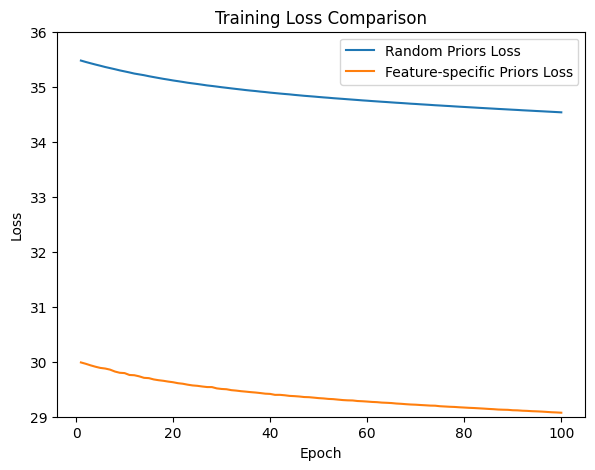

In [74]:
# -------------------------------
# Step 7: Plot Results
# -------------------------------
epochs = range(1, len(train_loss_a)+1)

plt.figure(figsize=(15,5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_a, label='Random Priors Loss')
plt.plot(epochs, train_loss_b, label='Feature-specific Priors Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(29, 36)
plt.title('Training Loss Comparison')
plt.legend()

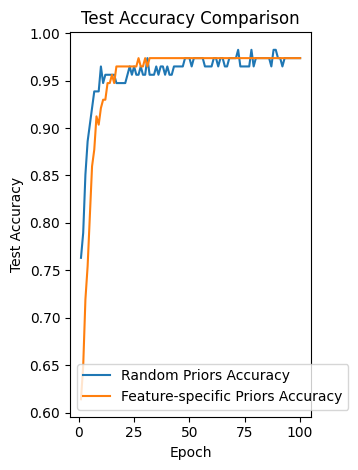


Final Accuracy (Random Priors): 97.37%
Final Accuracy (Feature-specific Priors): 97.37%


In [70]:
# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, test_acc_a, label='Random Priors Accuracy')
plt.plot(epochs, test_acc_b, label='Feature-specific Priors Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy Comparison')
plt.legend()

plt.tight_layout()
plt.show()

# Final results
print(f"\nFinal Accuracy (Random Priors): {test_acc_a[-1]*100:.2f}%")
print(f"Final Accuracy (Feature-specific Priors): {test_acc_b[-1]*100:.2f}%")